# List for storing unscaled model results

In [ ]:
all_model_metrics = []

# SARIMAX Lag 1 (Unscaled)


--- Feature Engineering: Creating Lagged Predictor ---
Aligned data points: 1094
Data head after lagging and aligning:
            Target_AQI_t  PM2.5_t_minus_1
DATE                                     
2022-01-02     26.000000              6.1
2022-01-03     52.000000              4.6
2022-01-04     29.000000              9.6
2022-01-05     32.666667              5.3
2022-01-06     39.000000              5.9

Training data points: 875
Test data points: 219

Building SARIMAX(1, 1, 1)x(1, 0, 1, 7) model...
Fitting the model...

--- SARIMAX Model Summary ---
                                     SARIMAX Results                                     
Dep. Variable:                      Target_AQI_t   No. Observations:                  875
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 7)   Log Likelihood               -3409.994
Date:                           Wed, 05 Nov 2025   AIC                           6831.989
Time:                                   17:16:53   BIC                      

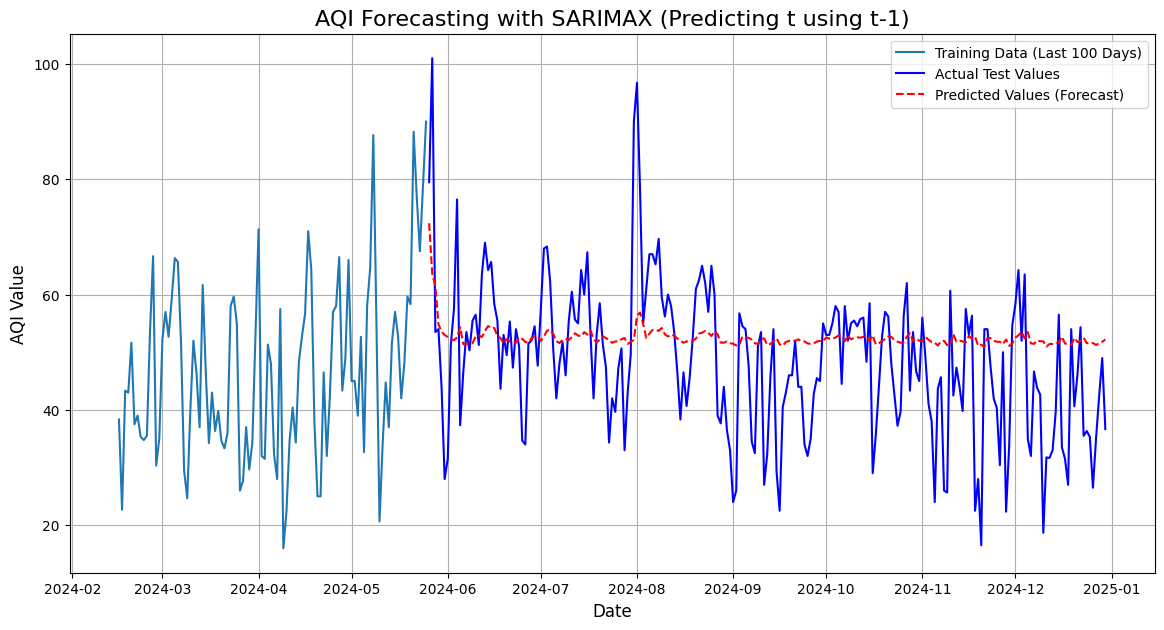

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import warnings

# Suppress common warnings from statsmodels
warnings.filterwarnings("ignore")

# -------------------------------------------------------------------
# 1. Load and Prepare the Dataset
# -------------------------------------------------------------------
try:
    file_name = 'LAG1_PM_Combined_AQI_2022_2024.csv'
    df = pd.read_csv(file_name)

    # Define our column names
    date_col = 'DATE'
    target_col = 'Daily_AQI_Value'
    exog_col = 'Daily_Mean_PM'

    # Prepare Date index (format='%d-%m-%y' is needed for your file)
    df[date_col] = pd.to_datetime(df[date_col], format='%d-%m-%y', errors='coerce')
    df = df.dropna(subset=[date_col])
    df.set_index(date_col, inplace=True)
    df.sort_index(inplace=True)

    # Select only the columns we will use
    df_clean = df[[target_col, exog_col]].copy()

    # Convert data columns to numbers, handling any errors
    df_clean[target_col] = pd.to_numeric(df_clean[target_col], errors='coerce')
    df_clean[exog_col] = pd.to_numeric(df_clean[exog_col], errors='coerce')

    # Set daily frequency ('D') and forward-fill missing values
    df_clean = df_clean.asfreq('D')
    df_clean.fillna(method='ffill', inplace=True)
    df_clean.dropna(inplace=True) # Drop any NaNs at the very start

    # -------------------------------------------------------------------
    # 2. Define Target (y) and Lagged Exogenous (X)
    # -------------------------------------------------------------------
    print("\n--- Feature Engineering: Creating Lagged Predictor ---")

    # Target (y): Today's AQI (t)
    y = df_clean[target_col].rename("Target_AQI_t")

    # Exogenous (X): Yesterday's PM2.5 (t-1)
    # This is our first input feature.
    X = df_clean[[exog_col]].shift(1).rename(columns={exog_col: "PM2.5_t_minus_1"})

    # Align y and X: Combine them and drop the first row (which has a NaN)
    combined_df = pd.concat([y, X], axis=1)
    combined_df.dropna(inplace=True)

    # Re-separate y and X now that they are perfectly aligned
    y_aligned = combined_df["Target_AQI_t"]
    X_aligned = combined_df[["PM2.5_t_minus_1"]]

    print(f"Aligned data points: {len(y_aligned)}")
    print("Data head after lagging and aligning:")
    print(combined_df.head())

    # Split data chronologically (80% train, 20% test)
    train_size = int(len(y_aligned) * 0.8)

    y_train, y_test = y_aligned[0:train_size], y_aligned[train_size:]
    X_train, X_test = X_aligned[0:train_size], X_aligned[train_size:]

    print(f"\nTraining data points: {len(y_train)}")
    print(f"Test data points: {len(y_test)}")

    # -------------------------------------------------------------------
    # 3. Build and Train the SARIMAX Model
    # -------------------------------------------------------------------
    print("\nBuilding SARIMAX(1, 1, 1)x(1, 0, 1, 7) model...")

    # Here we define BOTH of our inputs:
    # 1. `exog=X_train`: This tells the model to use our 'PM2.5_t_minus_1' feature.
    # 2. `order=(1, 1, 1)`: The first '1' (p=1) tells the model to *also* use
    #    'Daily_AQI_Value(t-1)' as an internal feature (this is the 'ar.L1' term).

    model = sm.tsa.SARIMAX(
        endog=y_train,     # Target (AQI at t)
        exog=X_train,     # Input 1: (PM2.5 at t-1)
        order=(1, 1, 1),  # Input 2: (AQI at t-1) is the '1'
        seasonal_order=(1, 0, 1, 7), # Use 7-day seasonal patterns
        enforce_stationarity=False,
        enforce_invertibility=False
    )

    # Train (fit) the model
    print("Fitting the model...")
    sarimax_model = model.fit(disp=False)

    print("\n--- SARIMAX Model Summary ---")
    print(sarimax_model.summary())

    # -------------------------------------------------------------------
    # 4. Make Predictions on the Test Set
    # -------------------------------------------------------------------
    print("\nMaking predictions on the test set...")

    # We must provide the X_test data (the PM2.5 values from t-1)
    # for the model to make its predictions.
    predictions = sarimax_model.predict(
        start=y_test.index[0],
        end=y_test.index[-1],
        exog=X_test # This provides the PM2.5(t-1) for the test period
    )
    predictions_series = predictions

    # -------------------------------------------------------------------
    # 5. Evaluate and Plot the Results
    # -------------------------------------------------------------------
    r2 = r2_score(y_test, predictions_series)
    rmse = np.sqrt(mean_squared_error(y_test, predictions_series))
    mae = mean_absolute_error(y_test, predictions_series)

    print("\n--- Model Evaluation (One-Step-Ahead Forecast) ---")
    print(f"Test R-squared (R²): {r2:.4f}")
    print(f"Mean Absolute Error (MAE):  {mae:.4f}")
    print(f"Test Root Mean Squared Error (RMSE): {rmse:.4f}")

    metrics_data = {
    'Model': ['LAG_1_Model'],
    'MAE': [mae],
    'RMSE': [rmse],
    'R-squared': [r2]
    }

    # Append dictionary to the list
    all_model_metrics.append(metrics_data)

    # Plot the results
    plt.figure(figsize=(14, 7))
    plt.plot(y_train.tail(100), label='Training Data (Last 100 Days)')
    plt.plot(y_test, color='blue', label='Actual Test Values')
    plt.plot(predictions_series, color='red', linestyle='--', label='Predicted Values (Forecast)')
    plt.title('AQI Forecasting with SARIMAX (Predicting t using t-1)', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('AQI Value', fontsize=12)
    plt.legend()
    plt.grid(True)

    # plt.savefig("sarimax_forecast_lagged.png")
    print("\nPlot saved as 'sarimax_forecast_lagged.png'")

except FileNotFoundError:
    print(f"Error: The file '{file_name}' was not found.")
except Exception as e:
    print(f"An error occurred: {e}")

# SARIMAX Lag 7 (Unscaled)


--- Feature Engineering: Creating Lagged Predictor ---
Aligned data points: 1088
Data head after lagging and aligning:
            Target_AQI_t  PM2.5_t_minus_7
DATE                                     
2022-01-08          61.0              6.1
2022-01-09          23.0              4.6
2022-01-10          31.0              9.6
2022-01-11          49.0              5.3
2022-01-12          35.0              5.9

Training data points: 870
Test data points: 218

Building SARIMAX(1, 1, 1)x(1, 0, 1, 7) model...
Fitting the model...

--- SARIMAX Model Summary ---
                                     SARIMAX Results                                      
Dep. Variable:                       Target_AQI_t   No. Observations:                  870
Model:             SARIMAX(0, 1, 1)x(1, 0, [], 7)   Log Likelihood               -3466.912
Date:                            Wed, 05 Nov 2025   AIC                           6941.825
Time:                                    17:16:54   BIC                 

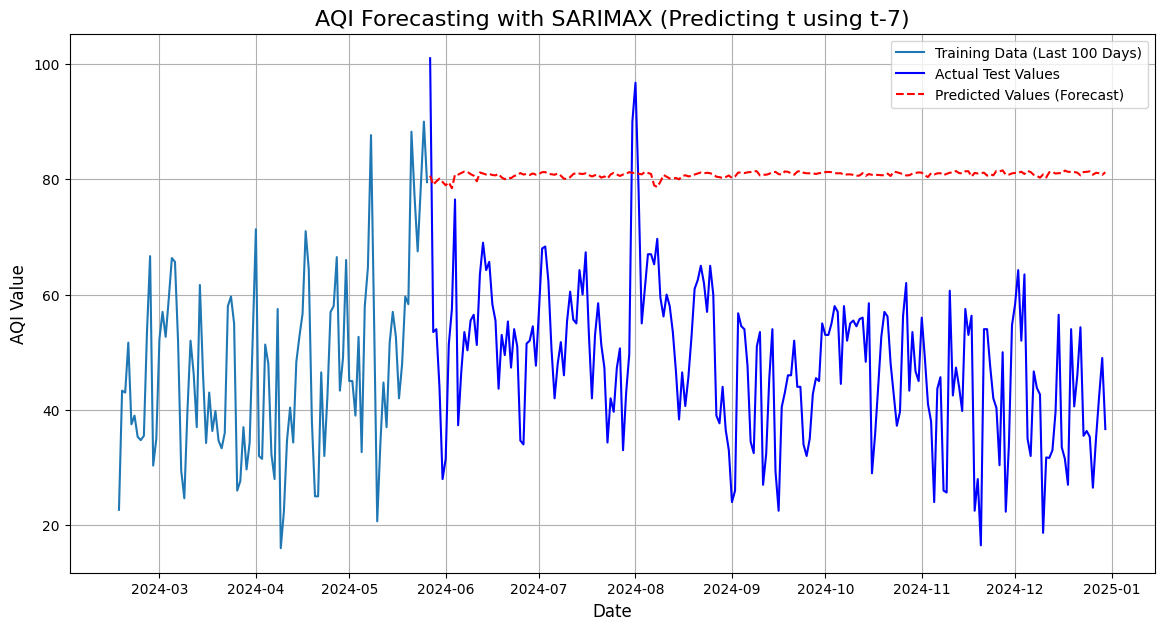

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import warnings

# Suppress common warnings from statsmodels
warnings.filterwarnings("ignore")

# -------------------------------------------------------------------
# 1. Load and Prepare the Dataset
# -------------------------------------------------------------------
try:
    file_name = 'LAG1_PM_Combined_AQI_2022_2024.csv'
    df = pd.read_csv(file_name)

    # Define our column names
    date_col = 'DATE'
    target_col = 'Daily_AQI_Value'
    exog_col = 'Daily_Mean_PM'

    # Prepare Date index (format='%d-%m-%y' is needed for your file)
    df[date_col] = pd.to_datetime(df[date_col], format='%d-%m-%y', errors='coerce')
    df = df.dropna(subset=[date_col])
    df.set_index(date_col, inplace=True)
    df.sort_index(inplace=True)

    # Select only the columns we will use
    df_clean = df[[target_col, exog_col]].copy()

    # Convert data columns to numbers, handling any errors
    df_clean[target_col] = pd.to_numeric(df_clean[target_col], errors='coerce')
    df_clean[exog_col] = pd.to_numeric(df_clean[exog_col], errors='coerce')

    # Set daily frequency ('D') and forward-fill missing values
    df_clean = df_clean.asfreq('D')
    df_clean.fillna(method='ffill', inplace=True)
    df_clean.dropna(inplace=True) # Drop any NaNs at the very start

    # -------------------------------------------------------------------
    # 2. Define Target (y) and Lagged Exogenous (X)
    # -------------------------------------------------------------------
    print("\n--- Feature Engineering: Creating Lagged Predictor ---")

    # Target (y): Today's AQI (t)
    y = df_clean[target_col].rename("Target_AQI_t")

    # Exogenous (X): Yesterday's PM2.5 (t-1)
    # This is our first input feature.
    X = df_clean[[exog_col]].shift(7).rename(columns={exog_col: "PM2.5_t_minus_7"})

    # Align y and X: Combine them and drop the first row (which has a NaN)
    combined_df = pd.concat([y, X], axis=1)
    combined_df.dropna(inplace=True)

    # Re-separate y and X now that they are perfectly aligned
    y_aligned = combined_df["Target_AQI_t"]
    X_aligned = combined_df[["PM2.5_t_minus_7"]]

    print(f"Aligned data points: {len(y_aligned)}")
    print("Data head after lagging and aligning:")
    print(combined_df.head())

    # Split data chronologically (80% train, 20% test)
    train_size = int(len(y_aligned) * 0.8)

    y_train, y_test = y_aligned[0:train_size], y_aligned[train_size:]
    X_train, X_test = X_aligned[0:train_size], X_aligned[train_size:]

    print(f"\nTraining data points: {len(y_train)}")
    print(f"Test data points: {len(y_test)}")

    # -------------------------------------------------------------------
    # 3. Build and Train the SARIMAX Model
    # -------------------------------------------------------------------
    print("\nBuilding SARIMAX(1, 1, 1)x(1, 0, 1, 7) model...")

    # Here we define BOTH of our inputs:
    # 1. `exog=X_train`: This tells the model to use our 'PM2.5_t_minus_1' feature.
    # 2. `order=(1, 1, 1)`: The first '1' (p=1) tells the model to *also* use
    #    'Daily_AQI_Value(t-1)' as an internal feature (this is the 'ar.L1' term).

    model = sm.tsa.SARIMAX(
        endog=y_train,     # Target (AQI at t)
        exog=X_train,     # Input 1: (PM2.5 at t-1)
        order=(0, 1, 1),  # Input 2: (AQI at t-1) is the '1'
        seasonal_order=(1, 0, 0, 7), # Use 7-day seasonal patterns
        enforce_stationarity=False,
        enforce_invertibility=False
    )

    # Train (fit) the model
    print("Fitting the model...")
    sarimax_model = model.fit(disp=False)

    print("\n--- SARIMAX Model Summary ---")
    print(sarimax_model.summary())

    # -------------------------------------------------------------------
    # 4. Make Predictions on the Test Set
    # -------------------------------------------------------------------
    print("\nMaking predictions on the test set...")

    # We must provide the X_test data (the PM2.5 values from t-1)
    # for the model to make its predictions.
    predictions = sarimax_model.predict(
        start=y_test.index[0],
        end=y_test.index[-1],
        exog=X_test # This provides the PM2.5(t-1) for the test period
    )
    predictions_series = predictions

    # -------------------------------------------------------------------
    # 5. Evaluate and Plot the Results
    # -------------------------------------------------------------------
    r2 = r2_score(y_test, predictions_series)
    rmse = np.sqrt(mean_squared_error(y_test, predictions_series))
    mae = mean_absolute_error(y_test, predictions_series)

    print("\n--- Model Evaluation (One-Step-Ahead Forecast) ---")
    print(f"Test R-squared (R²): {r2:.4f}")
    print(f"Mean Absolute Error (MAE):  {mae:.4f}")
    print(f"Test Root Mean Squared Error (RMSE): {rmse:.4f}")

    metrics_data = {
    'Model': 'LAG_7_Model',
    'MAE': mae,
    'RMSE': rmse,
    'R-squared': r2
    }

    # Append dictionary to the list
    all_model_metrics.append(metrics_data)

    # Plot the results
    plt.figure(figsize=(14, 7))
    plt.plot(y_train.tail(100), label='Training Data (Last 100 Days)')
    plt.plot(y_test, color='blue', label='Actual Test Values')
    plt.plot(predictions_series, color='red', linestyle='--', label='Predicted Values (Forecast)')
    plt.title('AQI Forecasting with SARIMAX (Predicting t using t-7)', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('AQI Value', fontsize=12)
    plt.legend()
    plt.grid(True)

    # plt.savefig("sarimax_forecast_lagged.png")
    print("\nPlot saved as 'sarimax_forecast_lagged.png'")

except FileNotFoundError:
    print(f"Error: The file '{file_name}' was not found.")
except Exception as e:
    print(f"An error occurred: {e}")

# SARIMAX Lag 14 (Unscaled)


--- Feature Engineering: Creating Lagged Predictor ---
Aligned data points: 1081
Data head after lagging and aligning:
            Target_AQI_t  PM2.5_t_minus_14
DATE                                      
2022-01-15         27.00               6.1
2022-01-16         55.00               4.6
2022-01-17         64.25               9.6
2022-01-18         37.00               5.3
2022-01-19         44.00               5.9

Training data points: 864
Test data points: 217

Building SARIMAX(1, 1, 1)x(1, 0, 1, 7) model...
Fitting the model...

--- SARIMAX Model Summary ---
                                      SARIMAX Results                                      
Dep. Variable:                        Target_AQI_t   No. Observations:                  864
Model:             SARIMAX(0, 1, 1)x(1, 0, [], 14)   Log Likelihood               -3409.500
Date:                             Wed, 05 Nov 2025   AIC                           6827.000
Time:                                     17:16:55   BIC     

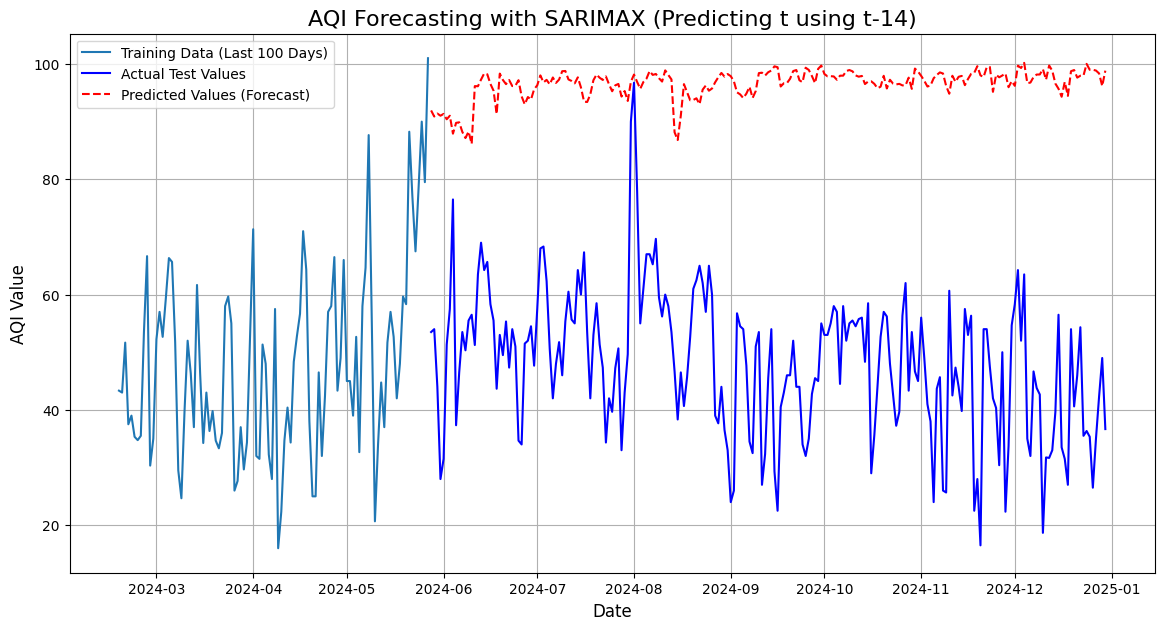

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import warnings

# Suppress common warnings from statsmodels
warnings.filterwarnings("ignore")

# -------------------------------------------------------------------
# 1. Load and Prepare the Dataset
# -------------------------------------------------------------------
try:
    file_name = 'LAG1_PM_Combined_AQI_2022_2024.csv'
    df = pd.read_csv(file_name)

    # Define our column names
    date_col = 'DATE'
    target_col = 'Daily_AQI_Value'
    exog_col = 'Daily_Mean_PM'

    # Prepare Date index (format='%d-%m-%y' is needed for your file)
    df[date_col] = pd.to_datetime(df[date_col], format='%d-%m-%y', errors='coerce')
    df = df.dropna(subset=[date_col])
    df.set_index(date_col, inplace=True)
    df.sort_index(inplace=True)

    # Select only the columns we will use
    df_clean = df[[target_col, exog_col]].copy()

    # Convert data columns to numbers, handling any errors
    df_clean[target_col] = pd.to_numeric(df_clean[target_col], errors='coerce')
    df_clean[exog_col] = pd.to_numeric(df_clean[exog_col], errors='coerce')

    # Set daily frequency ('D') and forward-fill missing values
    df_clean = df_clean.asfreq('D')
    df_clean.fillna(method='ffill', inplace=True)
    df_clean.dropna(inplace=True) # Drop any NaNs at the very start

    # -------------------------------------------------------------------
    # 2. Define Target (y) and Lagged Exogenous (X)
    # -------------------------------------------------------------------
    print("\n--- Feature Engineering: Creating Lagged Predictor ---")

    # Target (y): Today's AQI (t)
    y = df_clean[target_col].rename("Target_AQI_t")

    # Exogenous (X): Yesterday's PM2.5 (t-1)
    # This is our first input feature.
    X = df_clean[[exog_col]].shift(14).rename(columns={exog_col: "PM2.5_t_minus_14"})

    # Align y and X: Combine them and drop the first row (which has a NaN)
    combined_df = pd.concat([y, X], axis=1)
    combined_df.dropna(inplace=True)

    # Re-separate y and X now that they are perfectly aligned
    y_aligned = combined_df["Target_AQI_t"]
    X_aligned = combined_df[["PM2.5_t_minus_14"]]

    print(f"Aligned data points: {len(y_aligned)}")
    print("Data head after lagging and aligning:")
    print(combined_df.head())

    # Split data chronologically (80% train, 20% test)
    train_size = int(len(y_aligned) * 0.8)

    y_train, y_test = y_aligned[0:train_size], y_aligned[train_size:]
    X_train, X_test = X_aligned[0:train_size], X_aligned[train_size:]

    print(f"\nTraining data points: {len(y_train)}")
    print(f"Test data points: {len(y_test)}")

    # -------------------------------------------------------------------
    # 3. Build and Train the SARIMAX Model
    # -------------------------------------------------------------------
    print("\nBuilding SARIMAX(1, 1, 1)x(1, 0, 1, 7) model...")

    # Here we define BOTH of our inputs:
    # 1. `exog=X_train`: This tells the model to use our 'PM2.5_t_minus_1' feature.
    # 2. `order=(1, 1, 1)`: The first '1' (p=1) tells the model to *also* use
    #    'Daily_AQI_Value(t-1)' as an internal feature (this is the 'ar.L1' term).

    model = sm.tsa.SARIMAX(
        endog=y_train,     # Target (AQI at t)
        exog=X_train,     # Input 1: (PM2.5 at t-1)
        order=(0, 1, 1),  # Input 2: (AQI at t-1) is the '1'
        seasonal_order=(1, 0, 0, 14), # Use 14-day seasonal patterns
        enforce_stationarity=False,
        enforce_invertibility=False
    )

    # Train (fit) the model
    print("Fitting the model...")
    sarimax_model = model.fit(disp=False)

    print("\n--- SARIMAX Model Summary ---")
    print(sarimax_model.summary())

    # -------------------------------------------------------------------
    # 4. Make Predictions on the Test Set
    # -------------------------------------------------------------------
    print("\nMaking predictions on the test set...")

    # We must provide the X_test data (the PM2.5 values from t-1)
    # for the model to make its predictions.
    predictions = sarimax_model.predict(
        start=y_test.index[0],
        end=y_test.index[-1],
        exog=X_test # This provides the PM2.5(t-1) for the test period
    )
    predictions_series = predictions

    # -------------------------------------------------------------------
    # 5. Evaluate and Plot the Results
    # -------------------------------------------------------------------
    r2 = r2_score(y_test, predictions_series)
    rmse = np.sqrt(mean_squared_error(y_test, predictions_series))
    mae = mean_absolute_error(y_test, predictions_series)

    print("\n--- Model Evaluation (One-Step-Ahead Forecast) ---")
    print(f"Test R-squared (R²): {r2:.4f}")
    print(f"Mean Absolute Error (MAE):  {mae:.4f}")
    print(f"Test Root Mean Squared Error (RMSE): {rmse:.4f}")

    metrics_data = {
    'Model': 'LAG_14_Model',
    'MAE': mae,
    'RMSE': rmse,
    'R-squared': r2
    }

    # Append dictionary to the list
    all_model_metrics.append(metrics_data)

    # Plot the results
    plt.figure(figsize=(14, 7))
    plt.plot(y_train.tail(100), label='Training Data (Last 100 Days)')
    plt.plot(y_test, color='blue', label='Actual Test Values')
    plt.plot(predictions_series, color='red', linestyle='--', label='Predicted Values (Forecast)')
    plt.title('AQI Forecasting with SARIMAX (Predicting t using t-14)', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('AQI Value', fontsize=12)
    plt.legend()
    plt.grid(True)

    # plt.savefig("sarimax_forecast_lagged.png")
    print("\nPlot saved as 'sarimax_forecast_lagged.png'")

except FileNotFoundError:
    print(f"Error: The file '{file_name}' was not found.")
except Exception as e:
    print(f"An error occurred: {e}")

# SARIMAX Lag 30 (Unscaled)


--- Feature Engineering: Creating Lagged Predictor ---
Aligned data points: 1065
Data head after lagging and aligning:
            Target_AQI_t  PM2.5_t_minus_30
DATE                                      
2022-01-31     19.000000               6.1
2022-02-01     24.500000               4.6
2022-02-02     21.000000               9.6
2022-02-03      6.000000               5.3
2022-02-04     41.333333               5.9

Training data points: 852
Test data points: 213

Building SARIMAX(1, 1, 1)x(1, 0, 1, 30) model...
Fitting the model...

--- SARIMAX Model Summary ---
                                      SARIMAX Results                                      
Dep. Variable:                        Target_AQI_t   No. Observations:                  852
Model:             SARIMAX(0, 1, 1)x(1, 0, [], 30)   Log Likelihood               -3293.665
Date:                             Wed, 05 Nov 2025   AIC                           6595.330
Time:                                     17:16:58   BIC    

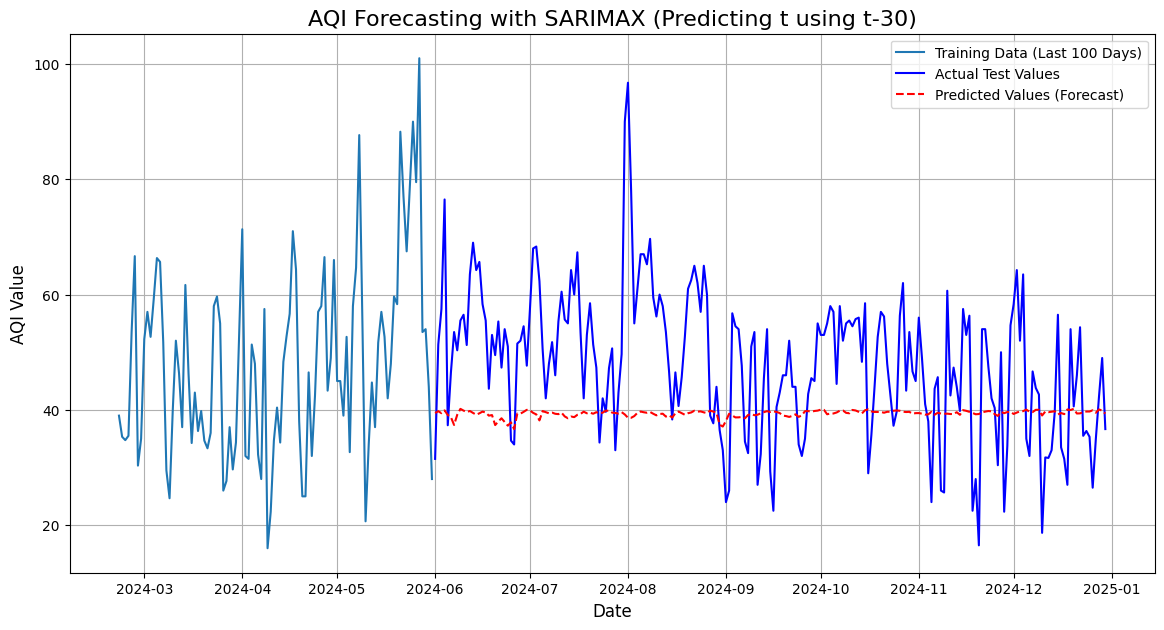

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import warnings

# Suppress common warnings from statsmodels
warnings.filterwarnings("ignore")

# -------------------------------------------------------------------
# 1. Load and Prepare the Dataset
# -------------------------------------------------------------------
try:
    file_name = 'LAG1_PM_Combined_AQI_2022_2024.csv'
    df = pd.read_csv(file_name)

    # Define our column names
    date_col = 'DATE'
    target_col = 'Daily_AQI_Value'
    exog_col = 'Daily_Mean_PM'

    # Prepare Date index (format='%d-%m-%y' is needed for your file)
    df[date_col] = pd.to_datetime(df[date_col], format='%d-%m-%y', errors='coerce')
    df = df.dropna(subset=[date_col])
    df.set_index(date_col, inplace=True)
    df.sort_index(inplace=True)

    # Select only the columns we will use
    df_clean = df[[target_col, exog_col]].copy()

    # Convert data columns to numbers, handling any errors
    df_clean[target_col] = pd.to_numeric(df_clean[target_col], errors='coerce')
    df_clean[exog_col] = pd.to_numeric(df_clean[exog_col], errors='coerce')

    # Set daily frequency ('D') and forward-fill missing values
    df_clean = df_clean.asfreq('D')
    df_clean.fillna(method='ffill', inplace=True)
    df_clean.dropna(inplace=True) # Drop any NaNs at the very start

    # -------------------------------------------------------------------
    # 2. Define Target (y) and Lagged Exogenous (X)
    # -------------------------------------------------------------------
    print("\n--- Feature Engineering: Creating Lagged Predictor ---")

    # Target (y): Today's AQI (t)
    y = df_clean[target_col].rename("Target_AQI_t")

    # Exogenous (X): Yesterday's PM2.5 (t-1)
    # This is our first input feature.
    X = df_clean[[exog_col]].shift(30).rename(columns={exog_col: "PM2.5_t_minus_30"})

    # Align y and X: Combine them and drop the first row (which has a NaN)
    combined_df = pd.concat([y, X], axis=1)
    combined_df.dropna(inplace=True)

    # Re-separate y and X now that they are perfectly aligned
    y_aligned = combined_df["Target_AQI_t"]
    X_aligned = combined_df[["PM2.5_t_minus_30"]]

    print(f"Aligned data points: {len(y_aligned)}")
    print("Data head after lagging and aligning:")
    print(combined_df.head())

    # Split data chronologically (80% train, 20% test)
    train_size = int(len(y_aligned) * 0.8)

    y_train, y_test = y_aligned[0:train_size], y_aligned[train_size:]
    X_train, X_test = X_aligned[0:train_size], X_aligned[train_size:]

    print(f"\nTraining data points: {len(y_train)}")
    print(f"Test data points: {len(y_test)}")

    # -------------------------------------------------------------------
    # 3. Build and Train the SARIMAX Model
    # -------------------------------------------------------------------
    print("\nBuilding SARIMAX(1, 1, 1)x(1, 0, 1, 30) model...")

    # Here we define BOTH of our inputs:
    # 1. `exog=X_train`: This tells the model to use our 'PM2.5_t_minus_1' feature.
    # 2. `order=(1, 1, 1)`: The first '1' (p=1) tells the model to *also* use
    #    'Daily_AQI_Value(t-1)' as an internal feature (this is the 'ar.L1' term).

    model = sm.tsa.SARIMAX(
        endog=y_train,     # Target (AQI at t)
        exog=X_train,     # Input 1: (PM2.5 at t-1)
        order=(0, 1, 1),  # Input 2: (AQI at t-1) is the '1'
        seasonal_order=(1, 0, 0, 30), # Use 14-day seasonal patterns
        enforce_stationarity=False,
        enforce_invertibility=False
    )

    # Train (fit) the model
    print("Fitting the model...")
    sarimax_model = model.fit(disp=False)

    print("\n--- SARIMAX Model Summary ---")
    print(sarimax_model.summary())

    # -------------------------------------------------------------------
    # 4. Make Predictions on the Test Set
    # -------------------------------------------------------------------
    print("\nMaking predictions on the test set...")

    # We must provide the X_test data (the PM2.5 values from t-1)
    # for the model to make its predictions.
    predictions = sarimax_model.predict(
        start=y_test.index[0],
        end=y_test.index[-1],
        exog=X_test # This provides the PM2.5(t-1) for the test period
    )
    predictions_series = predictions

    # -------------------------------------------------------------------
    # 5. Evaluate and Plot the Results
    # -------------------------------------------------------------------
    r2 = r2_score(y_test, predictions_series)
    rmse = np.sqrt(mean_squared_error(y_test, predictions_series))
    mae = mean_absolute_error(y_test, predictions_series)

    print("\n--- Model Evaluation (One-Step-Ahead Forecast) ---")
    print(f"Test R-squared (R²): {r2:.4f}")
    print(f"Mean Absolute Error (MAE):  {mae:.4f}")
    print(f"Test Root Mean Squared Error (RMSE): {rmse:.4f}")

    metrics_data = {
    'Model': 'LAG_30_Model',
    'MAE': mae,
    'RMSE': rmse,
    'R-squared': r2
    }

    # Append dictionary to the list
    all_model_metrics.append(metrics_data)

    # Plot the results
    plt.figure(figsize=(14, 7))
    plt.plot(y_train.tail(100), label='Training Data (Last 100 Days)')
    plt.plot(y_test, color='blue', label='Actual Test Values')
    plt.plot(predictions_series, color='red', linestyle='--', label='Predicted Values (Forecast)')
    plt.title('AQI Forecasting with SARIMAX (Predicting t using t-30)', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('AQI Value', fontsize=12)
    plt.legend()
    plt.grid(True)

    # plt.savefig("sarimax_forecast_lagged.png")
    print("\nPlot saved as 'sarimax_forecast_lagged.png'")

except FileNotFoundError:
    print(f"Error: The file '{file_name}' was not found.")
except Exception as e:
    print(f"An error occurred: {e}")

In [ ]:
# After all models are run, convert the list into a DataFrame
final_metrics_df = pd.DataFrame(all_model_metrics)

# Save the single, complete DataFrame to a file
final_metrics_df.to_csv('all_model_metrics_comparison.csv', index=False)
print("\nFinal metrics saved to 'all_model_metrics_comparison.csv'")

print("\n--- Final Model Comparison DataFrame ---")
final_metrics_df.head()


Final metrics saved to 'all_model_metrics_comparison.csv'

--- Final Model Comparison DataFrame ---


,Model,MAE,RMSE,R-squared
0,[LAG_1_Model],[9.885465071668813],[12.927265959880772],[0.01699027286169541]
1,LAG_7_Model,32.917436,34.985265,-6.358166
2,LAG_14_Model,48.446616,50.144218,-15.300296
3,LAG_30_Model,12.480968,15.218562,-0.495399


# List for storing scaled model results

In [ ]:
all_model_metrics_scaled = []

#SARIMAX LAG 1 (Scaled)


--- Feature Engineering: Creating Lagged Predictor ---
Aligned data points: 1094

--- Scaling Data (Fit on Train, Transform Both) ---
Data scaled. Mean of X_train is approx 0, Std is approx 1.

Building SARIMAX(0, 1, 1)x(1, 0, 0, 7) model...
Fitting the model...

--- SARIMAX Model Summary ---
                                     SARIMAX Results                                     
Dep. Variable:                      Target_AQI_t   No. Observations:                  875
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 7)   Log Likelihood                -929.315
Date:                           Mon, 15 Dec 2025   AIC                           1870.630
Time:                                   12:55:35   BIC                           1899.206
Sample:                               01-02-2022   HQIC                          1881.567
                                    - 05-25-2024                                         
Covariance Type:                             opg                           

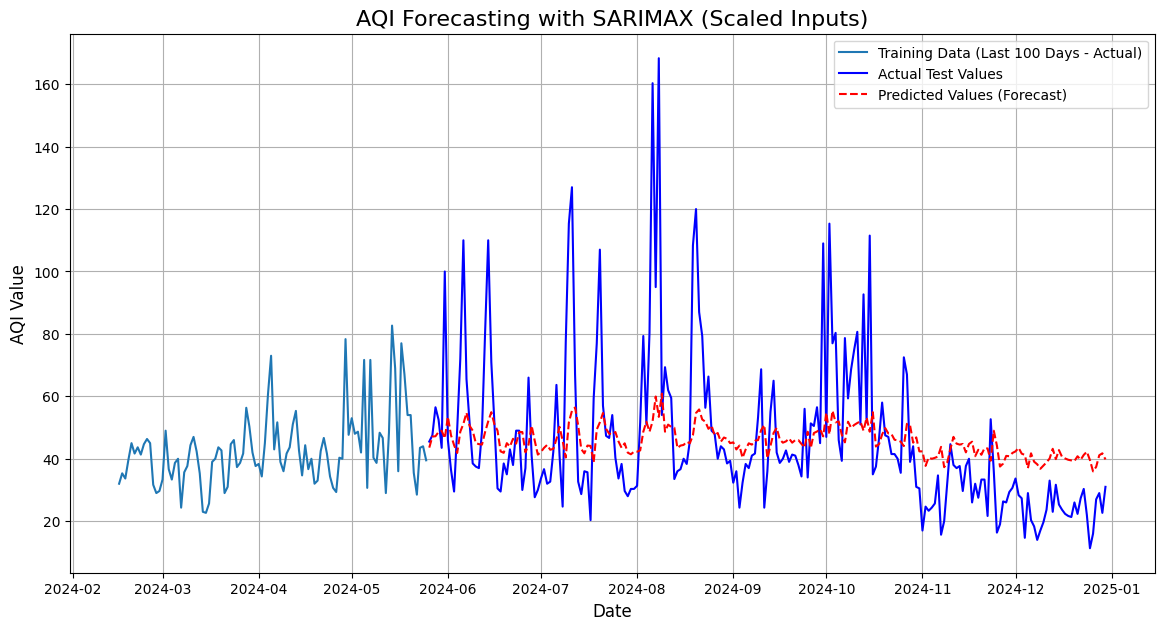

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler  # <--- IMPORT ADDED
import warnings

# Suppress common warnings from statsmodels
warnings.filterwarnings("ignore")

# Initialize a list to store metrics (assuming this exists in your wider workflow)
all_model_metrics = []

# -------------------------------------------------------------------
# 1. Load and Prepare the Dataset
# -------------------------------------------------------------------
try:
    file_name = 'LAG1_PM_Combined_AQI_2022_2024.csv'
    df = pd.read_csv(file_name)

    # Define our column names
    date_col = 'DATE'
    target_col = 'Daily_AQI_Value'
    exog_col = 'Daily_Mean_PM'

    # Prepare Date index
    df[date_col] = pd.to_datetime(df[date_col], format='%d-%m-%Y', errors='coerce')
    df = df.dropna(subset=[date_col])
    df.set_index(date_col, inplace=True)
    df.sort_index(inplace=True)

    # Select only the columns we will use
    df_clean = df[[target_col, exog_col]].copy()

    # Convert data columns to numbers
    df_clean[target_col] = pd.to_numeric(df_clean[target_col], errors='coerce')
    df_clean[exog_col] = pd.to_numeric(df_clean[exog_col], errors='coerce')

    # Set daily frequency ('D') and forward-fill missing values
    df_clean = df_clean.asfreq('D')
    df_clean.fillna(method='ffill', inplace=True)
    df_clean.dropna(inplace=True)

    # -------------------------------------------------------------------
    # 2. Define Target (y) and Lagged Exogenous (X)
    # -------------------------------------------------------------------
    print("\n--- Feature Engineering: Creating Lagged Predictor ---")

    y = df_clean[target_col].rename("Target_AQI_t")
    X = df_clean[[exog_col]].shift(1).rename(columns={exog_col: "PM2.5_t_minus_1"})

    combined_df = pd.concat([y, X], axis=1)
    combined_df.dropna(inplace=True)

    y_aligned = combined_df["Target_AQI_t"]
    X_aligned = combined_df[["PM2.5_t_minus_1"]]

    print(f"Aligned data points: {len(y_aligned)}")

    # Split data chronologically (80% train, 20% test)
    train_size = int(len(y_aligned) * 0.8)

    # Raw splits (we keep y_test unscaled for final evaluation comparison)
    y_train_raw, y_test = y_aligned[0:train_size], y_aligned[train_size:]
    X_train_raw, X_test_raw = X_aligned[0:train_size], X_aligned[train_size:]

    # -------------------------------------------------------------------
    # 2b. SCALING (New Section)
    # -------------------------------------------------------------------
    print("\n--- Scaling Data (Fit on Train, Transform Both) ---")

    # Initialize Scalers
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    # 1. Scale X (Exogenous)
    # Fit on Train
    X_train_scaled_vals = scaler_X.fit_transform(X_train_raw)
    # Transform Test
    X_test_scaled_vals = scaler_X.transform(X_test_raw)

    # Re-attach the date index (SARIMAX needs the index)
    X_train = pd.DataFrame(X_train_scaled_vals, index=X_train_raw.index, columns=X_train_raw.columns)
    X_test = pd.DataFrame(X_test_scaled_vals, index=X_test_raw.index, columns=X_test_raw.columns)

    # 2. Scale y (Target)
    # Reshape is needed because scaler expects 2D array, but y is a Series
    y_train_scaled_vals = scaler_y.fit_transform(y_train_raw.values.reshape(-1, 1))

    # Re-attach index and flatten back to 1D array for SARIMAX
    y_train = pd.Series(y_train_scaled_vals.flatten(), index=y_train_raw.index, name="Target_AQI_t")

    print("Data scaled. Mean of X_train is approx 0, Std is approx 1.")

    # -------------------------------------------------------------------
    # 3. Build and Train the SARIMAX Model
    # -------------------------------------------------------------------
    print("\nBuilding SARIMAX(0, 1, 1)x(1, 0, 0, 7) model...")

    # Note: We are passing the SCALED y_train and SCALED X_train
    model = sm.tsa.SARIMAX(
        endog=y_train,
        exog=X_train,
        order=(1, 1, 1),
        seasonal_order=(1, 0, 1, 7),
        enforce_stationarity=False,
        enforce_invertibility=False
    )

    print("Fitting the model...")
    sarimax_model = model.fit(disp=False)

    print("\n--- SARIMAX Model Summary ---")
    print(sarimax_model.summary())

    # -------------------------------------------------------------------
    # 4. Make Predictions on the Test Set
    # -------------------------------------------------------------------
    print("\nMaking predictions on the test set...")

    # Predict using SCALED X_test
    # The output `predictions_scaled` will be in the scaled units (Z-scores)
    predictions_scaled = sarimax_model.predict(
        start=y_test.index[0],
        end=y_test.index[-1],
        exog=X_test
    )

    # --- INVERSE TRANSFORM ---
    # We must convert the predicted Z-scores back to AQI values
    pred_reshaped = predictions_scaled.values.reshape(-1, 1)
    predictions_original = scaler_y.inverse_transform(pred_reshaped)

    # Convert back to Pandas Series for plotting/metrics
    predictions_series = pd.Series(predictions_original.flatten(), index=y_test.index)

    # -------------------------------------------------------------------
    # 5. Evaluate and Plot the Results
    # -------------------------------------------------------------------
    # We compare predictions_series (unscaled) vs y_test (unscaled)
    r2 = r2_score(y_test, predictions_series)
    rmse = np.sqrt(mean_squared_error(y_test, predictions_series))
    mae = mean_absolute_error(y_test, predictions_series)

     # Calculate Mean Squared Error (MSE)
    mse = np.mean((y_test - predictions_series)**2)

    # Calculate the variance (power) of the true values
    # The mean is calculated implicitly here, you can also use np.var(y_true)
    variance_true = np.mean((y_test - np.mean(predictions_series))**2)

    nmse = mse / variance_true

    print("\n--- Model Evaluation (One-Step-Ahead Forecast) ---")
    print(f"Test R-squared (R²): {r2:.4f}")
    print(f"Mean Absolute Error (MAE):  {mae:.4f}")
    print(f"Test Root Mean Squared Error (RMSE): {rmse:.4f}")

    metrics_data = {
        'Model': 'LAG_1_Model',
        'MAE': mae,
        'RMSE': rmse,
        'R-squared': r2,
        'NMSE': nmse
    }
    all_model_metrics_scaled.append(metrics_data)

    # Plot the results
    plt.figure(figsize=(14, 7))
    # Plot original y_train (unscaled) for context, or scaled if you prefer
    plt.plot(y_train_raw.tail(100), label='Training Data (Last 100 Days - Actual)')
    plt.plot(y_test, color='blue', label='Actual Test Values')
    plt.plot(predictions_series, color='red', linestyle='--', label='Predicted Values (Forecast)')
    plt.title('AQI Forecasting with SARIMAX (Scaled Inputs)', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('AQI Value', fontsize=12)
    plt.legend()
    plt.grid(True)

    print("\nPlot displayed.")
    plt.show()

except FileNotFoundError:
    print(f"Error: The file '{file_name}' was not found.")
except Exception as e:
    print(f"An error occurred: {e}")

#SARIMAX LAG 7 (Scaled)


--- Feature Engineering: Creating Lagged Predictor ---
Aligned data points: 1088

--- Scaling Data (Fit on Train, Transform Both) ---
Data scaled. Mean of X_train is approx 0, Std is approx 1.

Building SARIMAX(0, 1, 1)x(1, 0, 0, 7) model...
Fitting the model...

--- SARIMAX Model Summary ---
                                     SARIMAX Results                                      
Dep. Variable:                       Target_AQI_t   No. Observations:                  870
Model:             SARIMAX(0, 1, 1)x(1, 0, [], 7)   Log Likelihood                -974.883
Date:                            Mon, 15 Dec 2025   AIC                           1957.766
Time:                                    12:55:37   BIC                           1976.804
Sample:                                01-08-2022   HQIC                          1965.054
                                     - 05-26-2024                                         
Covariance Type:                              opg                   

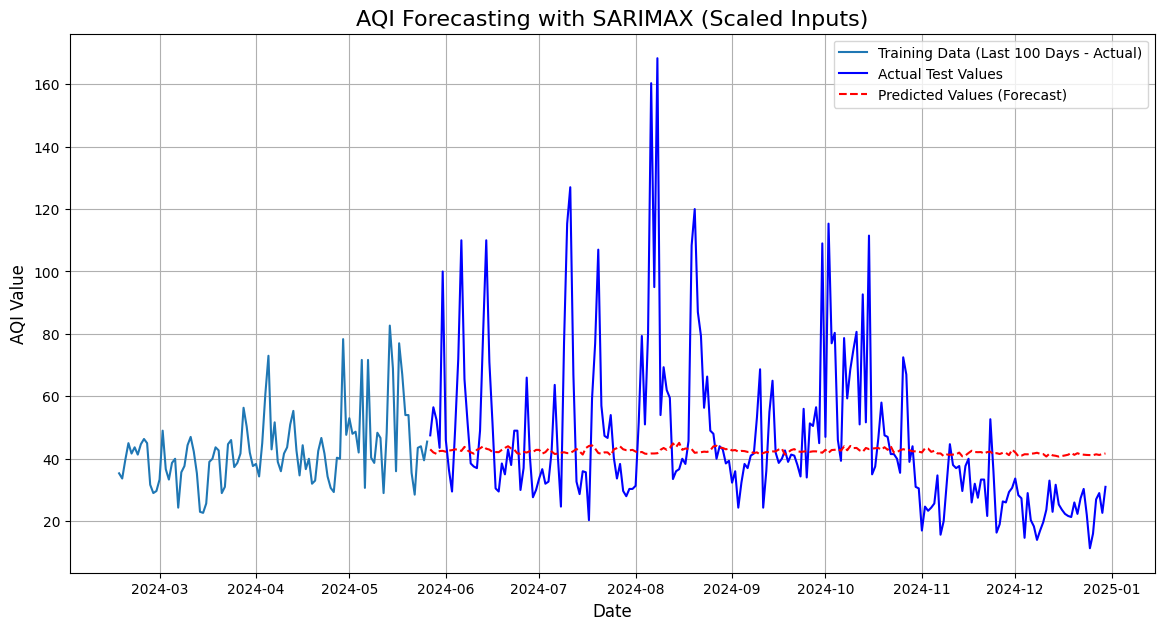

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler  # <--- IMPORT ADDED
import warnings

# Suppress common warnings from statsmodels
warnings.filterwarnings("ignore")

# Initialize a list to store metrics (assuming this exists in your wider workflow)
all_model_metrics = []

# -------------------------------------------------------------------
# 1. Load and Prepare the Dataset
# -------------------------------------------------------------------
try:
    file_name = 'LAG1_PM_Combined_AQI_2022_2024.csv'
    df = pd.read_csv(file_name)

    # Define our column names
    date_col = 'DATE'
    target_col = 'Daily_AQI_Value'
    exog_col = 'Daily_Mean_PM'

    # Prepare Date index
    df[date_col] = pd.to_datetime(df[date_col], format='%d-%m-%Y', errors='coerce')
    df = df.dropna(subset=[date_col])
    df.set_index(date_col, inplace=True)
    df.sort_index(inplace=True)

    # Select only the columns we will use
    df_clean = df[[target_col, exog_col]].copy()

    # Convert data columns to numbers
    df_clean[target_col] = pd.to_numeric(df_clean[target_col], errors='coerce')
    df_clean[exog_col] = pd.to_numeric(df_clean[exog_col], errors='coerce')

    # Set daily frequency ('D') and forward-fill missing values
    df_clean = df_clean.asfreq('D')
    df_clean.fillna(method='ffill', inplace=True)
    df_clean.dropna(inplace=True)

    # -------------------------------------------------------------------
    # 2. Define Target (y) and Lagged Exogenous (X)
    # -------------------------------------------------------------------
    print("\n--- Feature Engineering: Creating Lagged Predictor ---")

    y = df_clean[target_col].rename("Target_AQI_t")
    X = df_clean[[exog_col]].shift(7).rename(columns={exog_col: "PM2.5_t_minus_7"})

    combined_df = pd.concat([y, X], axis=1)
    combined_df.dropna(inplace=True)

    y_aligned = combined_df["Target_AQI_t"]
    X_aligned = combined_df[["PM2.5_t_minus_7"]]

    print(f"Aligned data points: {len(y_aligned)}")

    # Split data chronologically (80% train, 20% test)
    train_size = int(len(y_aligned) * 0.8)

    # Raw splits (we keep y_test unscaled for final evaluation comparison)
    y_train_raw, y_test = y_aligned[0:train_size], y_aligned[train_size:]
    X_train_raw, X_test_raw = X_aligned[0:train_size], X_aligned[train_size:]

    # -------------------------------------------------------------------
    # 2b. SCALING (New Section)
    # -------------------------------------------------------------------
    print("\n--- Scaling Data (Fit on Train, Transform Both) ---")

    # Initialize Scalers
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    # 1. Scale X (Exogenous)
    # Fit on Train
    X_train_scaled_vals = scaler_X.fit_transform(X_train_raw)
    # Transform Test
    X_test_scaled_vals = scaler_X.transform(X_test_raw)

    # Re-attach the date index (SARIMAX needs the index)
    X_train = pd.DataFrame(X_train_scaled_vals, index=X_train_raw.index, columns=X_train_raw.columns)
    X_test = pd.DataFrame(X_test_scaled_vals, index=X_test_raw.index, columns=X_test_raw.columns)

    # 2. Scale y (Target)
    # Reshape is needed because scaler expects 2D array, but y is a Series
    y_train_scaled_vals = scaler_y.fit_transform(y_train_raw.values.reshape(-1, 1))

    # Re-attach index and flatten back to 1D array for SARIMAX
    y_train = pd.Series(y_train_scaled_vals.flatten(), index=y_train_raw.index, name="Target_AQI_t")

    print("Data scaled. Mean of X_train is approx 0, Std is approx 1.")

    # -------------------------------------------------------------------
    # 3. Build and Train the SARIMAX Model
    # -------------------------------------------------------------------
    print("\nBuilding SARIMAX(0, 1, 1)x(1, 0, 0, 7) model...")

    # Note: We are passing the SCALED y_train and SCALED X_train
    model = sm.tsa.SARIMAX(
        endog=y_train,
        exog=X_train,
        order=(0, 1, 1),
        seasonal_order=(1, 0, 0, 7),
        enforce_stationarity=False,
        enforce_invertibility=False
    )

    print("Fitting the model...")
    sarimax_model = model.fit(disp=False)

    print("\n--- SARIMAX Model Summary ---")
    print(sarimax_model.summary())

    # -------------------------------------------------------------------
    # 4. Make Predictions on the Test Set
    # -------------------------------------------------------------------
    print("\nMaking predictions on the test set...")

    # Predict using SCALED X_test
    # The output `predictions_scaled` will be in the scaled units (Z-scores)
    predictions_scaled = sarimax_model.predict(
        start=y_test.index[0],
        end=y_test.index[-1],
        exog=X_test
    )

    # --- INVERSE TRANSFORM ---
    # We must convert the predicted Z-scores back to AQI values
    pred_reshaped = predictions_scaled.values.reshape(-1, 1)
    predictions_original = scaler_y.inverse_transform(pred_reshaped)

    # Convert back to Pandas Series for plotting/metrics
    predictions_series = pd.Series(predictions_original.flatten(), index=y_test.index)

    # -------------------------------------------------------------------
    # 5. Evaluate and Plot the Results
    # -------------------------------------------------------------------
    # We compare predictions_series (unscaled) vs y_test (unscaled)
    r2 = r2_score(y_test, predictions_series)
    rmse = np.sqrt(mean_squared_error(y_test, predictions_series))
    mae = mean_absolute_error(y_test, predictions_series)

     # Calculate Mean Squared Error (MSE)
    mse = np.mean((y_test - predictions_series)**2)

    # Calculate the variance (power) of the true values
    # The mean is calculated implicitly here, you can also use np.var(y_true)
    variance_true = np.mean((y_test - np.mean(predictions_series))**2)

    nmse = mse / variance_true

    print("\n--- Model Evaluation (One-Step-Ahead Forecast) ---")
    print(f"Test R-squared (R²): {r2:.4f}")
    print(f"Mean Absolute Error (MAE):  {mae:.4f}")
    print(f"Test Root Mean Squared Error (RMSE): {rmse:.4f}")

    metrics_data = {
        'Model': 'LAG_7_Model',
        'MAE': mae,
        'RMSE': rmse,
        'R-squared': r2,
        'NMSE': nmse
    }
    all_model_metrics_scaled.append(metrics_data)

    # Plot the results
    plt.figure(figsize=(14, 7))
    # Plot original y_train (unscaled) for context, or scaled if you prefer
    plt.plot(y_train_raw.tail(100), label='Training Data (Last 100 Days - Actual)')
    plt.plot(y_test, color='blue', label='Actual Test Values')
    plt.plot(predictions_series, color='red', linestyle='--', label='Predicted Values (Forecast)')
    plt.title('AQI Forecasting with SARIMAX (Scaled Inputs)', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('AQI Value', fontsize=12)
    plt.legend()
    plt.grid(True)

    print("\nPlot displayed.")
    plt.show()

except FileNotFoundError:
    print(f"Error: The file '{file_name}' was not found.")
except Exception as e:
    print(f"An error occurred: {e}")

#SARIMAX LAG 14 (Scaled)


--- Feature Engineering: Creating Lagged Predictor ---
Aligned data points: 1081

--- Scaling Data (Fit on Train, Transform Both) ---
Data scaled. Mean of X_train is approx 0, Std is approx 1.

Building SARIMAX(0, 1, 1)x(1, 0, 0, 14) model...
Fitting the model...

--- SARIMAX Model Summary ---
                                      SARIMAX Results                                      
Dep. Variable:                        Target_AQI_t   No. Observations:                  864
Model:             SARIMAX(0, 1, 1)x(1, 0, [], 14)   Log Likelihood                -964.815
Date:                             Mon, 15 Dec 2025   AIC                           1937.630
Time:                                     12:55:45   BIC                           1956.606
Sample:                                 01-15-2022   HQIC                          1944.899
                                      - 05-27-2024                                         
Covariance Type:                               opg          

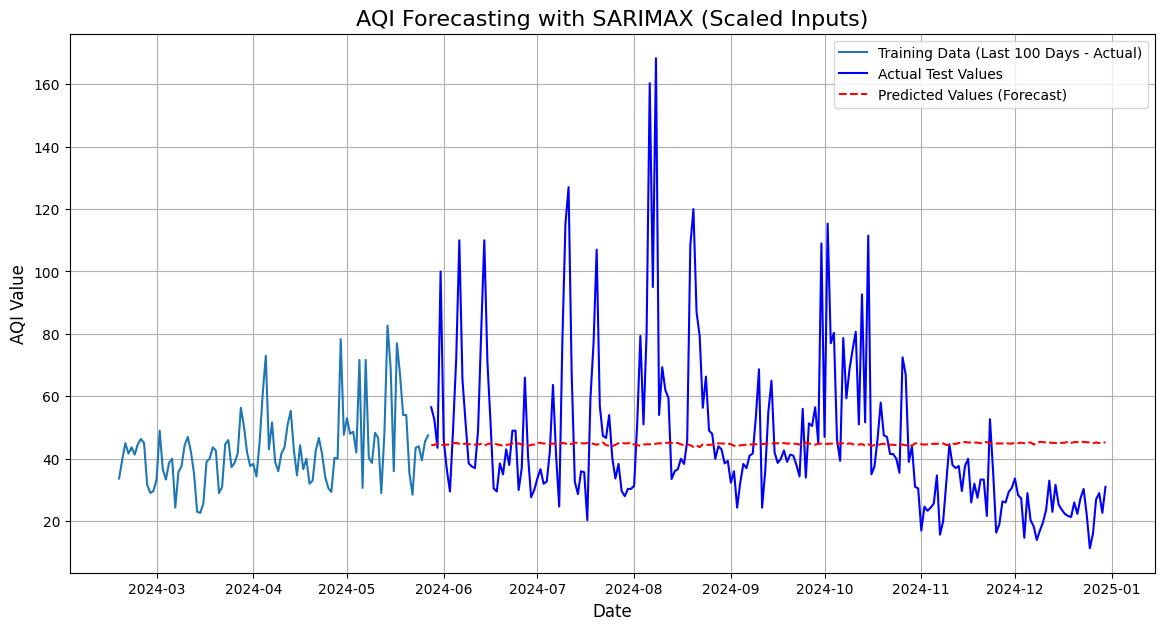

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler  # <--- IMPORT ADDED
import warnings

# Suppress common warnings from statsmodels
warnings.filterwarnings("ignore")

# Initialize a list to store metrics (assuming this exists in your wider workflow)
all_model_metrics = []

# -------------------------------------------------------------------
# 1. Load and Prepare the Dataset
# -------------------------------------------------------------------
try:
    file_name = 'LAG1_PM_Combined_AQI_2022_2024.csv'
    df = pd.read_csv(file_name)

    # Define our column names
    date_col = 'DATE'
    target_col = 'Daily_AQI_Value'
    exog_col = 'Daily_Mean_PM'

    # Prepare Date index
    df[date_col] = pd.to_datetime(df[date_col], format='%d-%m-%Y', errors='coerce')
    df = df.dropna(subset=[date_col])
    df.set_index(date_col, inplace=True)
    df.sort_index(inplace=True)

    # Select only the columns we will use
    df_clean = df[[target_col, exog_col]].copy()

    # Convert data columns to numbers
    df_clean[target_col] = pd.to_numeric(df_clean[target_col], errors='coerce')
    df_clean[exog_col] = pd.to_numeric(df_clean[exog_col], errors='coerce')

    # Set daily frequency ('D') and forward-fill missing values
    df_clean = df_clean.asfreq('D')
    df_clean.fillna(method='ffill', inplace=True)
    df_clean.dropna(inplace=True)

    # -------------------------------------------------------------------
    # 2. Define Target (y) and Lagged Exogenous (X)
    # -------------------------------------------------------------------
    print("\n--- Feature Engineering: Creating Lagged Predictor ---")

    y = df_clean[target_col].rename("Target_AQI_t")
    X = df_clean[[exog_col]].shift(14).rename(columns={exog_col: "PM2.5_t_minus_14"})

    combined_df = pd.concat([y, X], axis=1)
    combined_df.dropna(inplace=True)

    y_aligned = combined_df["Target_AQI_t"]
    X_aligned = combined_df[["PM2.5_t_minus_14"]]

    print(f"Aligned data points: {len(y_aligned)}")

    # Split data chronologically (80% train, 20% test)
    train_size = int(len(y_aligned) * 0.8)

    # Raw splits (we keep y_test unscaled for final evaluation comparison)
    y_train_raw, y_test = y_aligned[0:train_size], y_aligned[train_size:]
    X_train_raw, X_test_raw = X_aligned[0:train_size], X_aligned[train_size:]

    # -------------------------------------------------------------------
    # 2b. SCALING (New Section)
    # -------------------------------------------------------------------
    print("\n--- Scaling Data (Fit on Train, Transform Both) ---")

    # Initialize Scalers
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    # 1. Scale X (Exogenous)
    # Fit on Train
    X_train_scaled_vals = scaler_X.fit_transform(X_train_raw)
    # Transform Test
    X_test_scaled_vals = scaler_X.transform(X_test_raw)

    # Re-attach the date index (SARIMAX needs the index)
    X_train = pd.DataFrame(X_train_scaled_vals, index=X_train_raw.index, columns=X_train_raw.columns)
    X_test = pd.DataFrame(X_test_scaled_vals, index=X_test_raw.index, columns=X_test_raw.columns)

    # 2. Scale y (Target)
    # Reshape is needed because scaler expects 2D array, but y is a Series
    y_train_scaled_vals = scaler_y.fit_transform(y_train_raw.values.reshape(-1, 1))

    # Re-attach index and flatten back to 1D array for SARIMAX
    y_train = pd.Series(y_train_scaled_vals.flatten(), index=y_train_raw.index, name="Target_AQI_t")

    print("Data scaled. Mean of X_train is approx 0, Std is approx 1.")

    # -------------------------------------------------------------------
    # 3. Build and Train the SARIMAX Model
    # -------------------------------------------------------------------
    print("\nBuilding SARIMAX(0, 1, 1)x(1, 0, 0, 14) model...")

    # Note: We are passing the SCALED y_train and SCALED X_train
    model = sm.tsa.SARIMAX(
        endog=y_train,
        exog=X_train,
        order=(0, 1, 1),
        seasonal_order=(1, 0, 0, 14),
        enforce_stationarity=False,
        enforce_invertibility=False
    )

    print("Fitting the model...")
    sarimax_model = model.fit(disp=False)

    print("\n--- SARIMAX Model Summary ---")
    print(sarimax_model.summary())

    # -------------------------------------------------------------------
    # 4. Make Predictions on the Test Set
    # -------------------------------------------------------------------
    print("\nMaking predictions on the test set...")

    # Predict using SCALED X_test
    # The output `predictions_scaled` will be in the scaled units (Z-scores)
    predictions_scaled = sarimax_model.predict(
        start=y_test.index[0],
        end=y_test.index[-1],
        exog=X_test
    )

    # --- INVERSE TRANSFORM ---
    # We must convert the predicted Z-scores back to AQI values
    pred_reshaped = predictions_scaled.values.reshape(-1, 1)
    predictions_original = scaler_y.inverse_transform(pred_reshaped)

    # Convert back to Pandas Series for plotting/metrics
    predictions_series = pd.Series(predictions_original.flatten(), index=y_test.index)

    # -------------------------------------------------------------------
    # 5. Evaluate and Plot the Results
    # -------------------------------------------------------------------
    # We compare predictions_series (unscaled) vs y_test (unscaled)
    r2 = r2_score(y_test, predictions_series)
    rmse = np.sqrt(mean_squared_error(y_test, predictions_series))
    mae = mean_absolute_error(y_test, predictions_series)

     # Calculate Mean Squared Error (MSE)
    mse = np.mean((y_test - predictions_series)**2)

    # Calculate the variance (power) of the true values
    # The mean is calculated implicitly here, you can also use np.var(y_true)
    variance_true = np.mean((y_test - np.mean(predictions_series))**2)

    nmse = mse / variance_true

    print("\n--- Model Evaluation (One-Step-Ahead Forecast) ---")
    print(f"Test R-squared (R²): {r2:.4f}")
    print(f"Mean Absolute Error (MAE):  {mae:.4f}")
    print(f"Test Root Mean Squared Error (RMSE): {rmse:.4f}")

    metrics_data = {
        'Model': 'LAG_14_Model',
        'MAE': mae,
        'RMSE': rmse,
        'R-squared': r2,
        'NMSE': nmse
    }
    all_model_metrics_scaled.append(metrics_data)

    # Plot the results
    plt.figure(figsize=(14, 7))
    # Plot original y_train (unscaled) for context, or scaled if you prefer
    plt.plot(y_train_raw.tail(100), label='Training Data (Last 100 Days - Actual)')
    plt.plot(y_test, color='blue', label='Actual Test Values')
    plt.plot(predictions_series, color='red', linestyle='--', label='Predicted Values (Forecast)')
    plt.title('AQI Forecasting with SARIMAX (Scaled Inputs)', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('AQI Value', fontsize=12)
    plt.legend()
    plt.grid(True)

    print("\nPlot displayed.")
    plt.show()

except FileNotFoundError:
    print(f"Error: The file '{file_name}' was not found.")
except Exception as e:
    print(f"An error occurred: {e}")

#SARIMAX LAG 30 (Scaled)


--- Feature Engineering: Creating Lagged Predictor ---
Aligned data points: 1065

--- Scaling Data (Fit on Train, Transform Both) ---
Data scaled. Mean of X_train is approx 0, Std is approx 1.

Building SARIMAX(0, 1, 1)x(1, 0, 0, 14) model...
Fitting the model...

--- SARIMAX Model Summary ---
                                      SARIMAX Results                                      
Dep. Variable:                        Target_AQI_t   No. Observations:                  852
Model:             SARIMAX(0, 1, 1)x(1, 0, [], 30)   Log Likelihood                -940.618
Date:                             Mon, 15 Dec 2025   AIC                           1889.235
Time:                                     12:55:55   BIC                           1908.077
Sample:                                 01-31-2022   HQIC                          1896.465
                                      - 05-31-2024                                         
Covariance Type:                               opg          

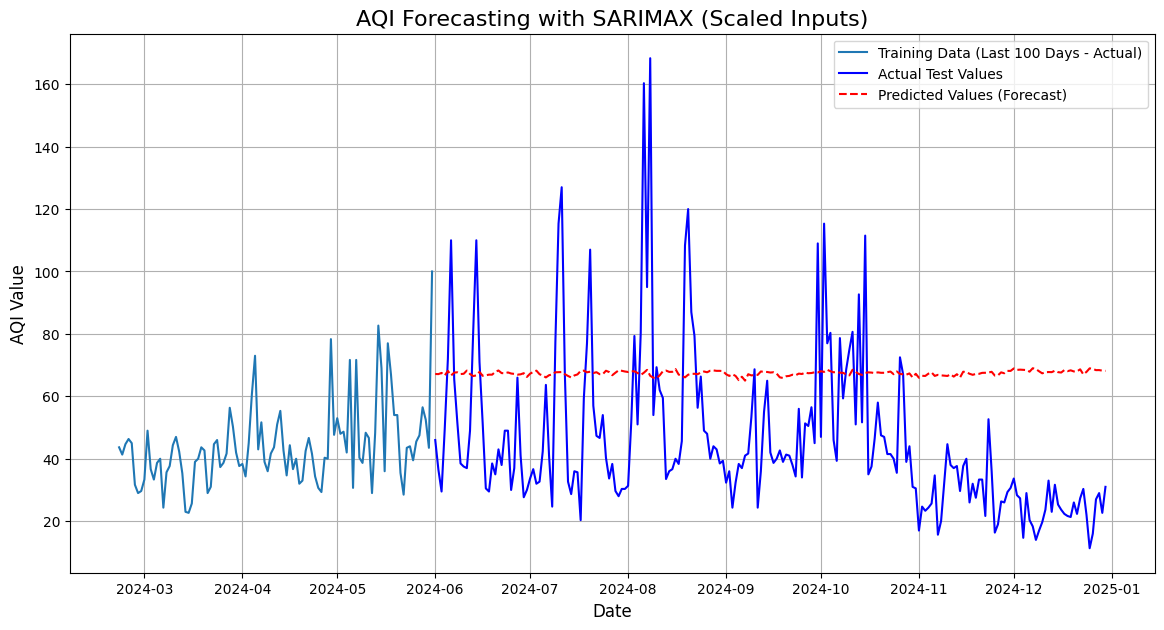

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler  # <--- IMPORT ADDED
import warnings

# Suppress common warnings from statsmodels
warnings.filterwarnings("ignore")

# Initialize a list to store metrics (assuming this exists in your wider workflow)
all_model_metrics = []

# -------------------------------------------------------------------
# 1. Load and Prepare the Dataset
# -------------------------------------------------------------------
try:
    file_name = 'LAG1_PM_Combined_AQI_2022_2024.csv'
    df = pd.read_csv(file_name)

    # Define our column names
    date_col = 'DATE'
    target_col = 'Daily_AQI_Value'
    exog_col = 'Daily_Mean_PM'

    # Prepare Date index
    df[date_col] = pd.to_datetime(df[date_col], format='%d-%m-%Y', errors='coerce')
    df = df.dropna(subset=[date_col])
    df.set_index(date_col, inplace=True)
    df.sort_index(inplace=True)

    # Select only the columns we will use
    df_clean = df[[target_col, exog_col]].copy()

    # Convert data columns to numbers
    df_clean[target_col] = pd.to_numeric(df_clean[target_col], errors='coerce')
    df_clean[exog_col] = pd.to_numeric(df_clean[exog_col], errors='coerce')

    # Set daily frequency ('D') and forward-fill missing values
    df_clean = df_clean.asfreq('D')
    df_clean.fillna(method='ffill', inplace=True)
    df_clean.dropna(inplace=True)

    # -------------------------------------------------------------------
    # 2. Define Target (y) and Lagged Exogenous (X)
    # -------------------------------------------------------------------
    print("\n--- Feature Engineering: Creating Lagged Predictor ---")

    y = df_clean[target_col].rename("Target_AQI_t")
    X = df_clean[[exog_col]].shift(30).rename(columns={exog_col: "PM2.5_t_minus_30"})

    combined_df = pd.concat([y, X], axis=1)
    combined_df.dropna(inplace=True)

    y_aligned = combined_df["Target_AQI_t"]
    X_aligned = combined_df[["PM2.5_t_minus_30"]]

    print(f"Aligned data points: {len(y_aligned)}")

    # Split data chronologically (80% train, 20% test)
    train_size = int(len(y_aligned) * 0.8)

    # Raw splits (we keep y_test unscaled for final evaluation comparison)
    y_train_raw, y_test = y_aligned[0:train_size], y_aligned[train_size:]
    X_train_raw, X_test_raw = X_aligned[0:train_size], X_aligned[train_size:]

    # -------------------------------------------------------------------
    # 2b. SCALING (New Section)
    # -------------------------------------------------------------------
    print("\n--- Scaling Data (Fit on Train, Transform Both) ---")

    # Initialize Scalers
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    # 1. Scale X (Exogenous)
    # Fit on Train
    X_train_scaled_vals = scaler_X.fit_transform(X_train_raw)
    # Transform Test
    X_test_scaled_vals = scaler_X.transform(X_test_raw)

    # Re-attach the date index (SARIMAX needs the index)
    X_train = pd.DataFrame(X_train_scaled_vals, index=X_train_raw.index, columns=X_train_raw.columns)
    X_test = pd.DataFrame(X_test_scaled_vals, index=X_test_raw.index, columns=X_test_raw.columns)

    # 2. Scale y (Target)
    # Reshape is needed because scaler expects 2D array, but y is a Series
    y_train_scaled_vals = scaler_y.fit_transform(y_train_raw.values.reshape(-1, 1))

    # Re-attach index and flatten back to 1D array for SARIMAX
    y_train = pd.Series(y_train_scaled_vals.flatten(), index=y_train_raw.index, name="Target_AQI_t")

    print("Data scaled. Mean of X_train is approx 0, Std is approx 1.")

    # -------------------------------------------------------------------
    # 3. Build and Train the SARIMAX Model
    # -------------------------------------------------------------------
    print("\nBuilding SARIMAX(0, 1, 1)x(1, 0, 0, 14) model...")

    # Note: We are passing the SCALED y_train and SCALED X_train
    model = sm.tsa.SARIMAX(
        endog=y_train,
        exog=X_train,
        order=(0, 1, 1),
        seasonal_order=(1, 0, 0, 30),
        enforce_stationarity=False,
        enforce_invertibility=False
    )

    print("Fitting the model...")
    sarimax_model = model.fit(disp=False)

    print("\n--- SARIMAX Model Summary ---")
    print(sarimax_model.summary())

    # -------------------------------------------------------------------
    # 4. Make Predictions on the Test Set
    # -------------------------------------------------------------------
    print("\nMaking predictions on the test set...")

    # Predict using SCALED X_test
    # The output `predictions_scaled` will be in the scaled units (Z-scores)
    predictions_scaled = sarimax_model.predict(
        start=y_test.index[0],
        end=y_test.index[-1],
        exog=X_test
    )

    # --- INVERSE TRANSFORM ---
    # We must convert the predicted Z-scores back to AQI values
    pred_reshaped = predictions_scaled.values.reshape(-1, 1)
    predictions_original = scaler_y.inverse_transform(pred_reshaped)

    # Convert back to Pandas Series for plotting/metrics
    predictions_series = pd.Series(predictions_original.flatten(), index=y_test.index)

    # -------------------------------------------------------------------
    # 5. Evaluate and Plot the Results
    # -------------------------------------------------------------------
    # We compare predictions_series (unscaled) vs y_test (unscaled)
    r2 = r2_score(y_test, predictions_series)
    rmse = np.sqrt(mean_squared_error(y_test, predictions_series))
    mae = mean_absolute_error(y_test, predictions_series)



    # Calculate Mean Squared Error (MSE)
    mse = np.mean((y_test - predictions_series)**2)

    # Calculate the variance (power) of the true values
    # The mean is calculated implicitly here, you can also use np.var(y_true)
    variance_true = np.mean((y_test - np.mean(predictions_series))**2)

    nmse = mse / variance_true

    print("\n--- Model Evaluation (One-Step-Ahead Forecast) ---")
    print(f"Test R-squared (R²): {r2:.4f}")
    print(f"Mean Absolute Error (MAE):  {mae:.4f}")
    print(f"Test Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Normalized Mean Squared Error (NMSE): {nmse:.4f}")

    metrics_data = {
        'Model': 'LAG_30_Model',
        'MAE': mae,
        'RMSE': rmse,
        'R-squared': r2,
        'NMSE': nmse
    }
    all_model_metrics_scaled.append(metrics_data)

    # Plot the results
    plt.figure(figsize=(14, 7))
    # Plot original y_train (unscaled) for context, or scaled if you prefer
    plt.plot(y_train_raw.tail(100), label='Training Data (Last 100 Days - Actual)')
    plt.plot(y_test, color='blue', label='Actual Test Values')
    plt.plot(predictions_series, color='red', linestyle='--', label='Predicted Values (Forecast)')
    plt.title('AQI Forecasting with SARIMAX (Scaled Inputs)', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('AQI Value', fontsize=12)
    plt.legend()
    plt.grid(True)

    print("\nPlot displayed.")
    plt.show()

except FileNotFoundError:
    print(f"Error: The file '{file_name}' was not found.")
except Exception as e:
    print(f"An error occurred: {e}")

In [ ]:
# After all models are run, convert the list into a DataFrame
final_metrics_df = pd.DataFrame(all_model_metrics_scaled)

# Save the single, complete DataFrame to a file
# final_metrics_df.to_csv('all_model_metrics_comparison.csv', index=False)
# print("\nFinal metrics saved to 'all_model_metrics_comparison.csv'")

print("\n--- Final Model Comparison DataFrame ---")
final_metrics_df.head()


--- Final Model Comparison DataFrame ---


,Model,MAE,RMSE,R-squared,NMSE
0,LAG_1_Model,15.597116,22.634680,0.193244,0.806552
1,LAG_7_Model,16.997681,25.422568,-0.013085,0.991074
2,LAG_14_Model,17.862196,25.461476,-0.011541,1.008711
3,LAG_30_Model,29.773307,33.316218,-0.738500,1.003809
